In [12]:
%cd /home/nahuel/ecg/generalization
%load_ext autoreload
%autoreload 2

/home/nahuel/ecg/generalization
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/nahuel/ecg/generalization/generalization/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [13]:
import matplotlib.pyplot as plt
import numpy as np
from data import data
import wfdb

### Datasets

**INCART**

Processing record 1/75
Processing record 2/75
Processing record 3/75
Processing record 4/75
Processing record 5/75
Processing record 6/75
Processing record 7/75
Processing record 8/75
Processing record 9/75
Processing record 10/75
Processing record 11/75
Processing record 12/75
Processing record 13/75
Processing record 14/75
Processing record 15/75
Processing record 16/75
Processing record 17/75
Processing record 18/75
Processing record 19/75
Processing record 20/75
Processing record 21/75
Processing record 22/75
Processing record 23/75
Processing record 24/75
Processing record 25/75
Processing record 26/75
Processing record 27/75
Processing record 28/75
Processing record 29/75
Processing record 30/75
Processing record 31/75
Processing record 32/75
Processing record 33/75
Processing record 34/75
Processing record 35/75
Processing record 36/75
Processing record 37/75
Processing record 38/75
Processing record 39/75
Processing record 40/75
Processing record 41/75
Processing record 42/75
P

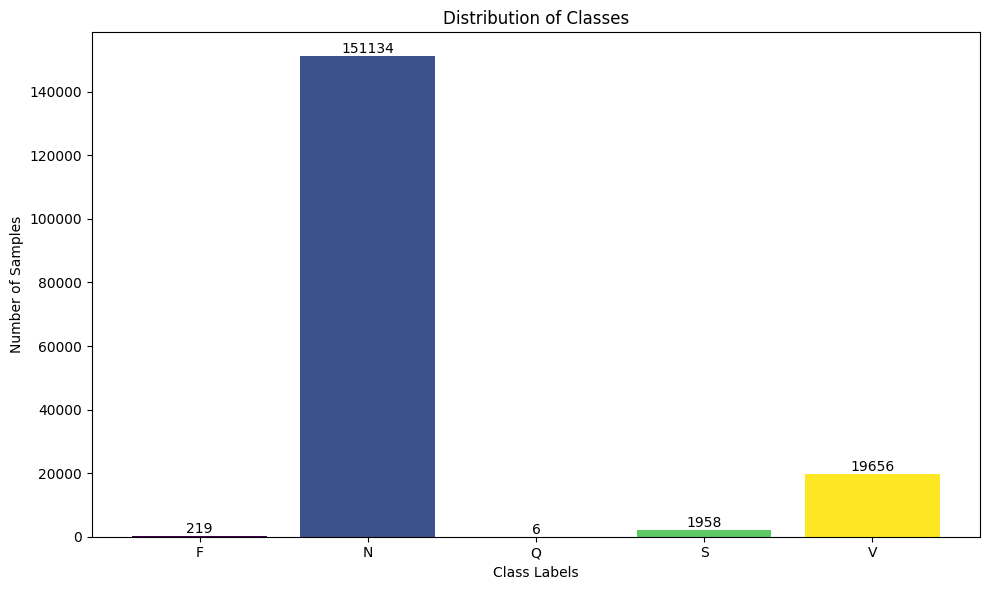

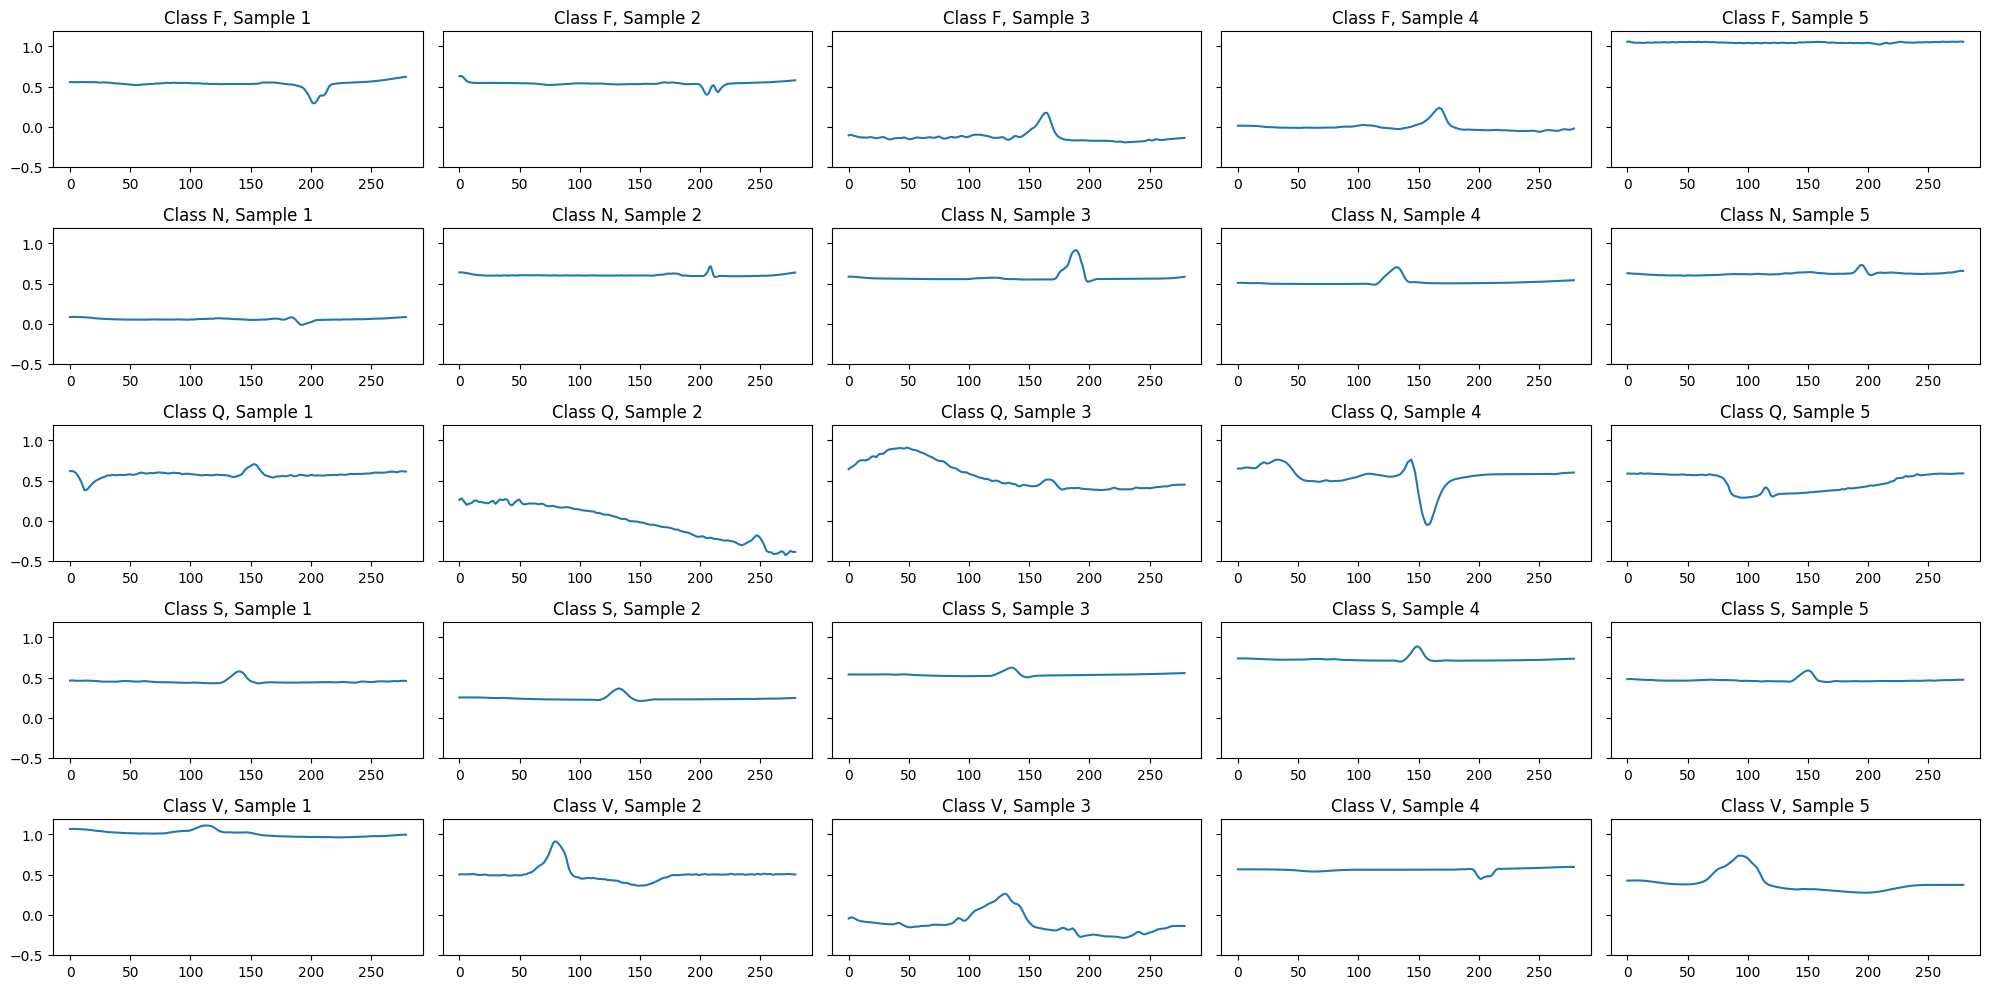

In [14]:
INCARTData = data.PhysioNetDataset('INCART', path='data/INCART')
record, annotation = INCARTData.__getitem__(0)
print("ECG shape:", record.p_signal.shape, end='\n')

print("\nkeys in record:")
for key in record.__dict__.keys():
    print('\t'+key+':'+str(record.__dict__[key]))

print("\nkeys in annotation")
for key in annotation.__dict__.keys():
    print('\t'+key+':'+str(annotation.__dict__[key]))

data.plot_info(INCARTData)

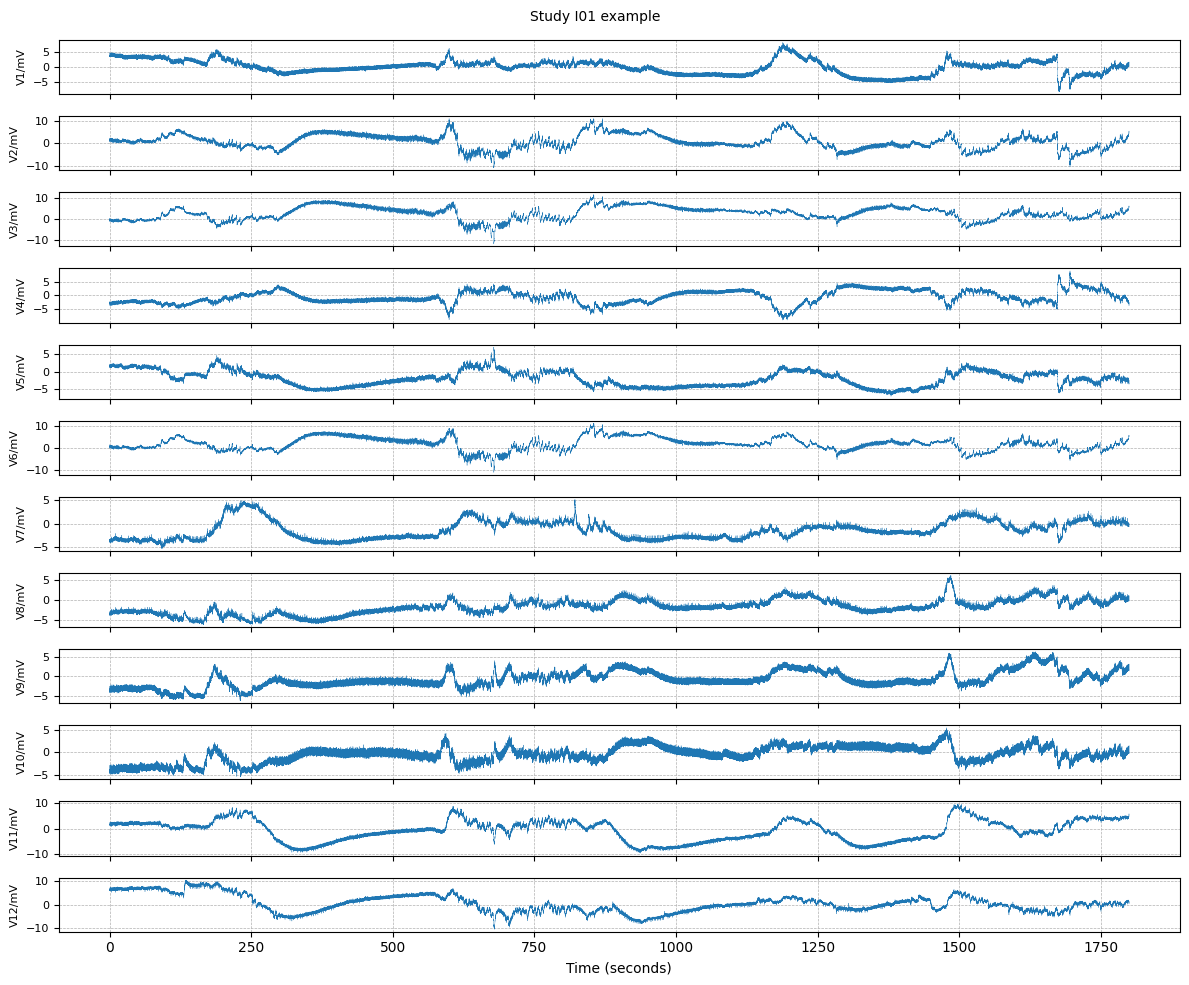

In [5]:
data.plot_ecg(record)

# también se puede hacer con lo siguiente, pero tarda mucho
#wfdb.plot_wfdb(record=record, annotation=annotation, plot_sym=True,
#                       time_units='seconds', title='MIT-BIH Record 100',
#                       figsize=(10,4), ecg_grids='all')

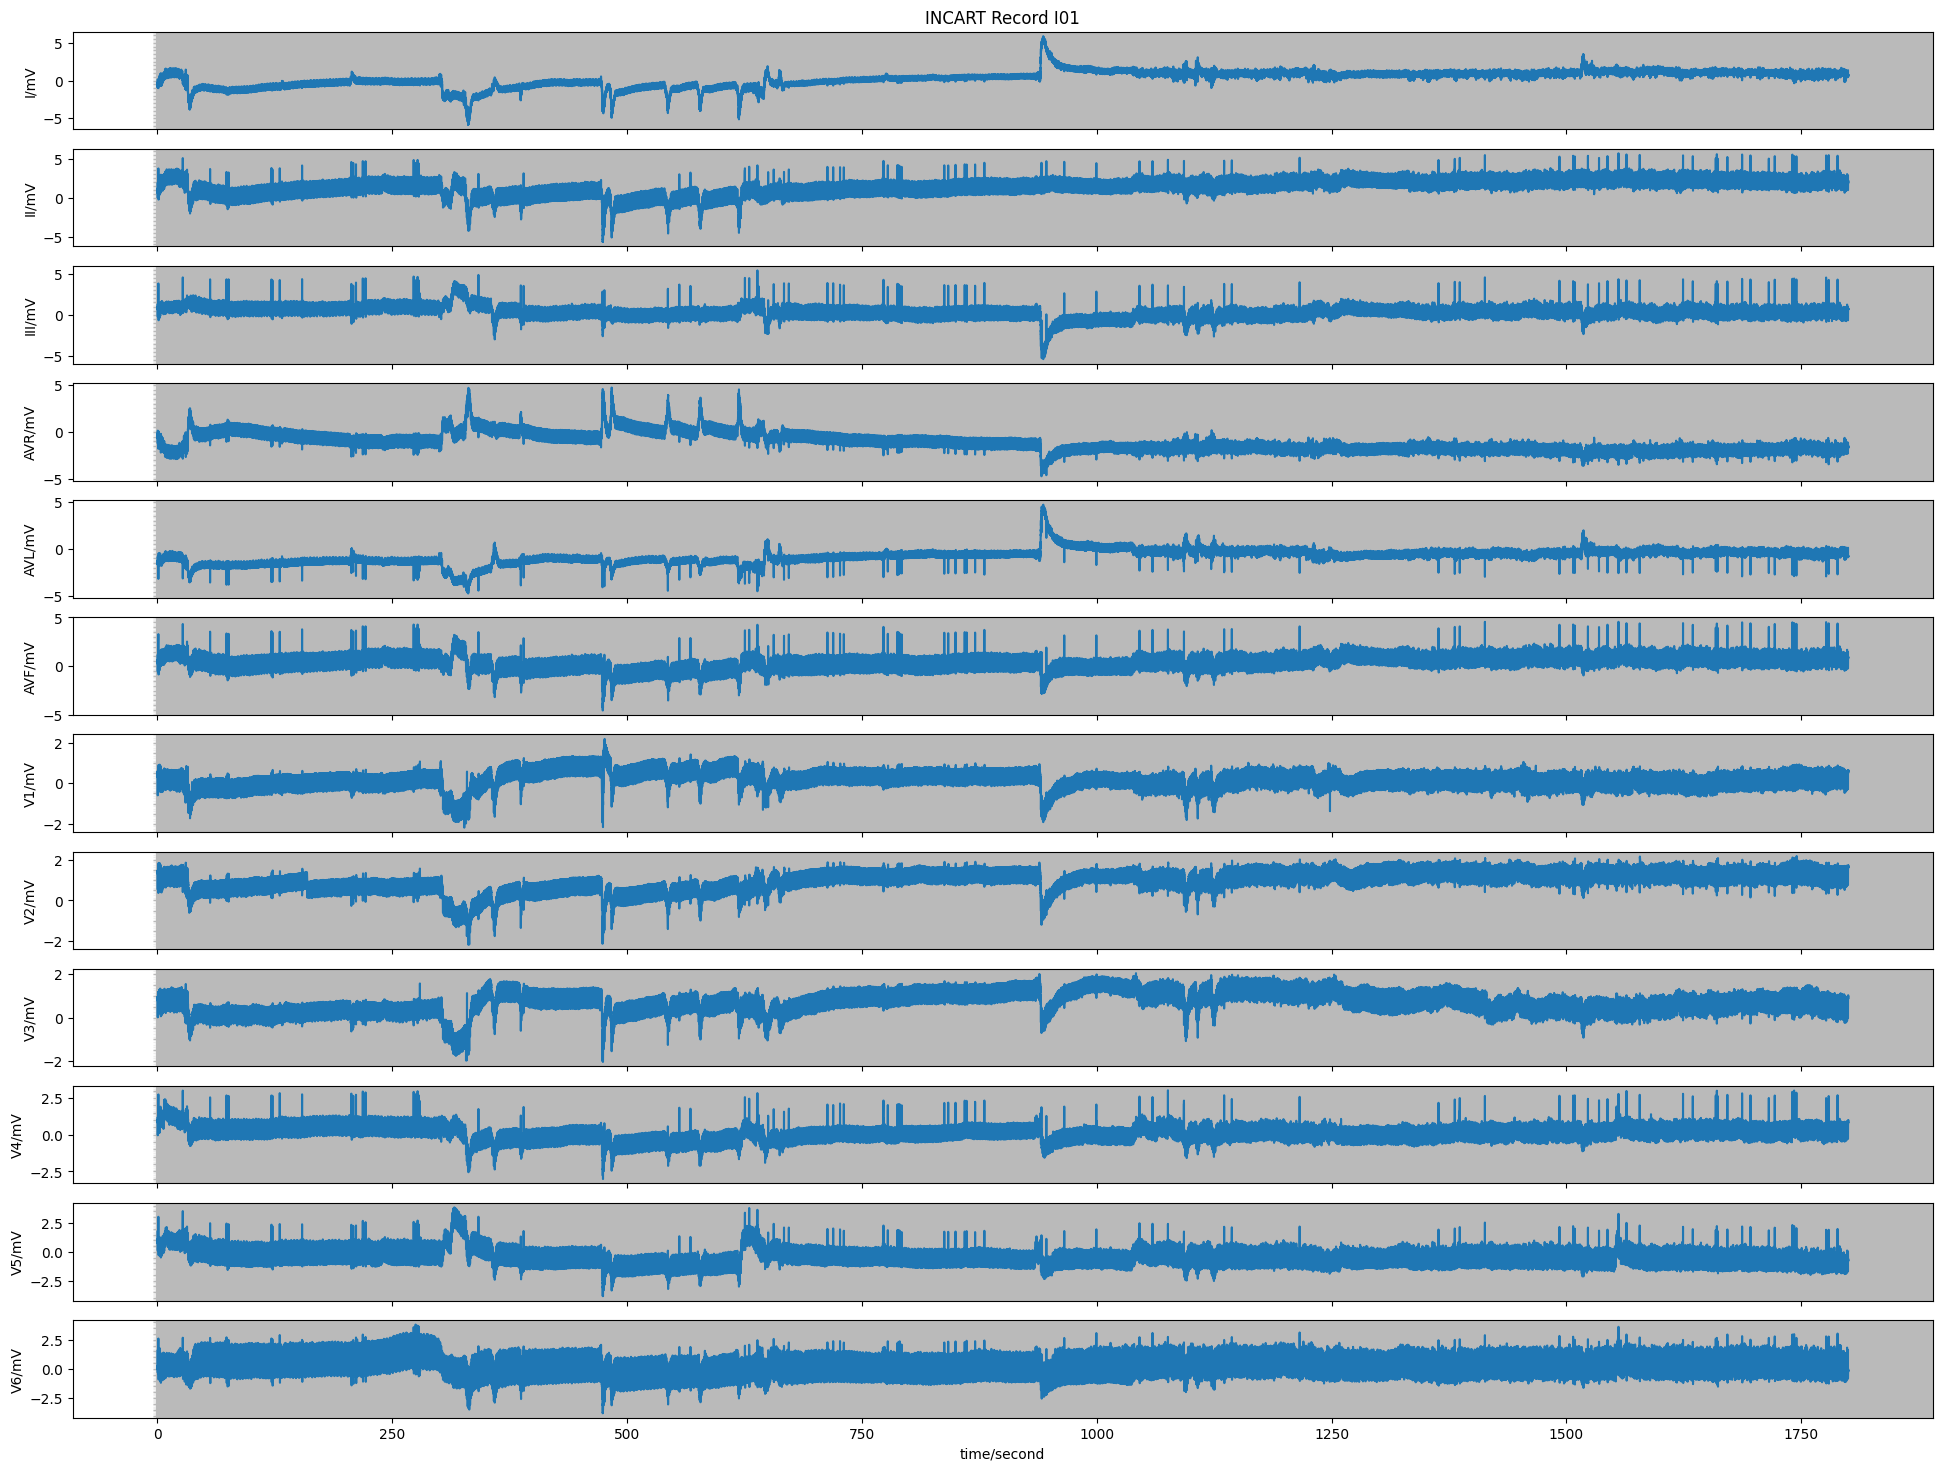

In [38]:
# Plot the ECG signal
wfdb.plot_wfdb(record=record, figsize=(24,18), title='INCART Record I01', ecg_grids='all')

**MIT-BIH**

Processing record 1/48
Processing record 2/48
Processing record 3/48
Processing record 4/48
Processing record 5/48
Processing record 6/48
Error in Tzone or Pzone: attempt to get argmax of an empty sequence
Error in Tzone or Pzone: attempt to get argmax of an empty sequence
Error in Tzone or Pzone: attempt to get argmax of an empty sequence
Processing record 7/48
Processing record 8/48
Processing record 9/48
Processing record 10/48
Processing record 11/48
Processing record 12/48
Error in Tzone or Pzone: attempt to get argmax of an empty sequence
Processing record 13/48
Processing record 14/48
Processing record 15/48
Processing record 16/48
Processing record 17/48
Processing record 18/48
Processing record 19/48
Processing record 20/48
Processing record 21/48
Processing record 22/48
Processing record 23/48
Processing record 24/48
Processing record 25/48
Processing record 26/48
Processing record 27/48
Error in Tzone or Pzone: attempt to get argmax of an empty sequence
Processing record 28/

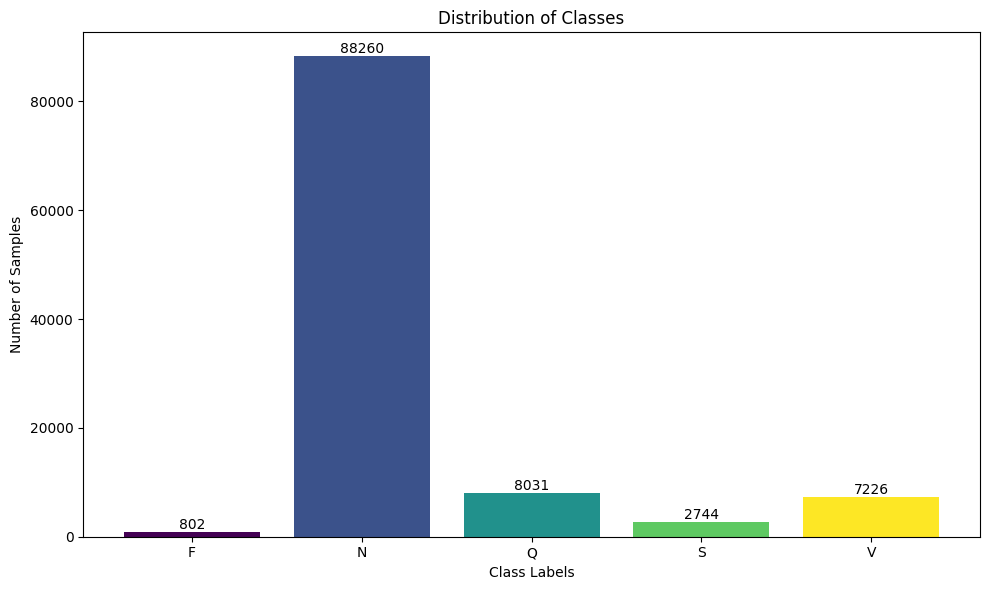

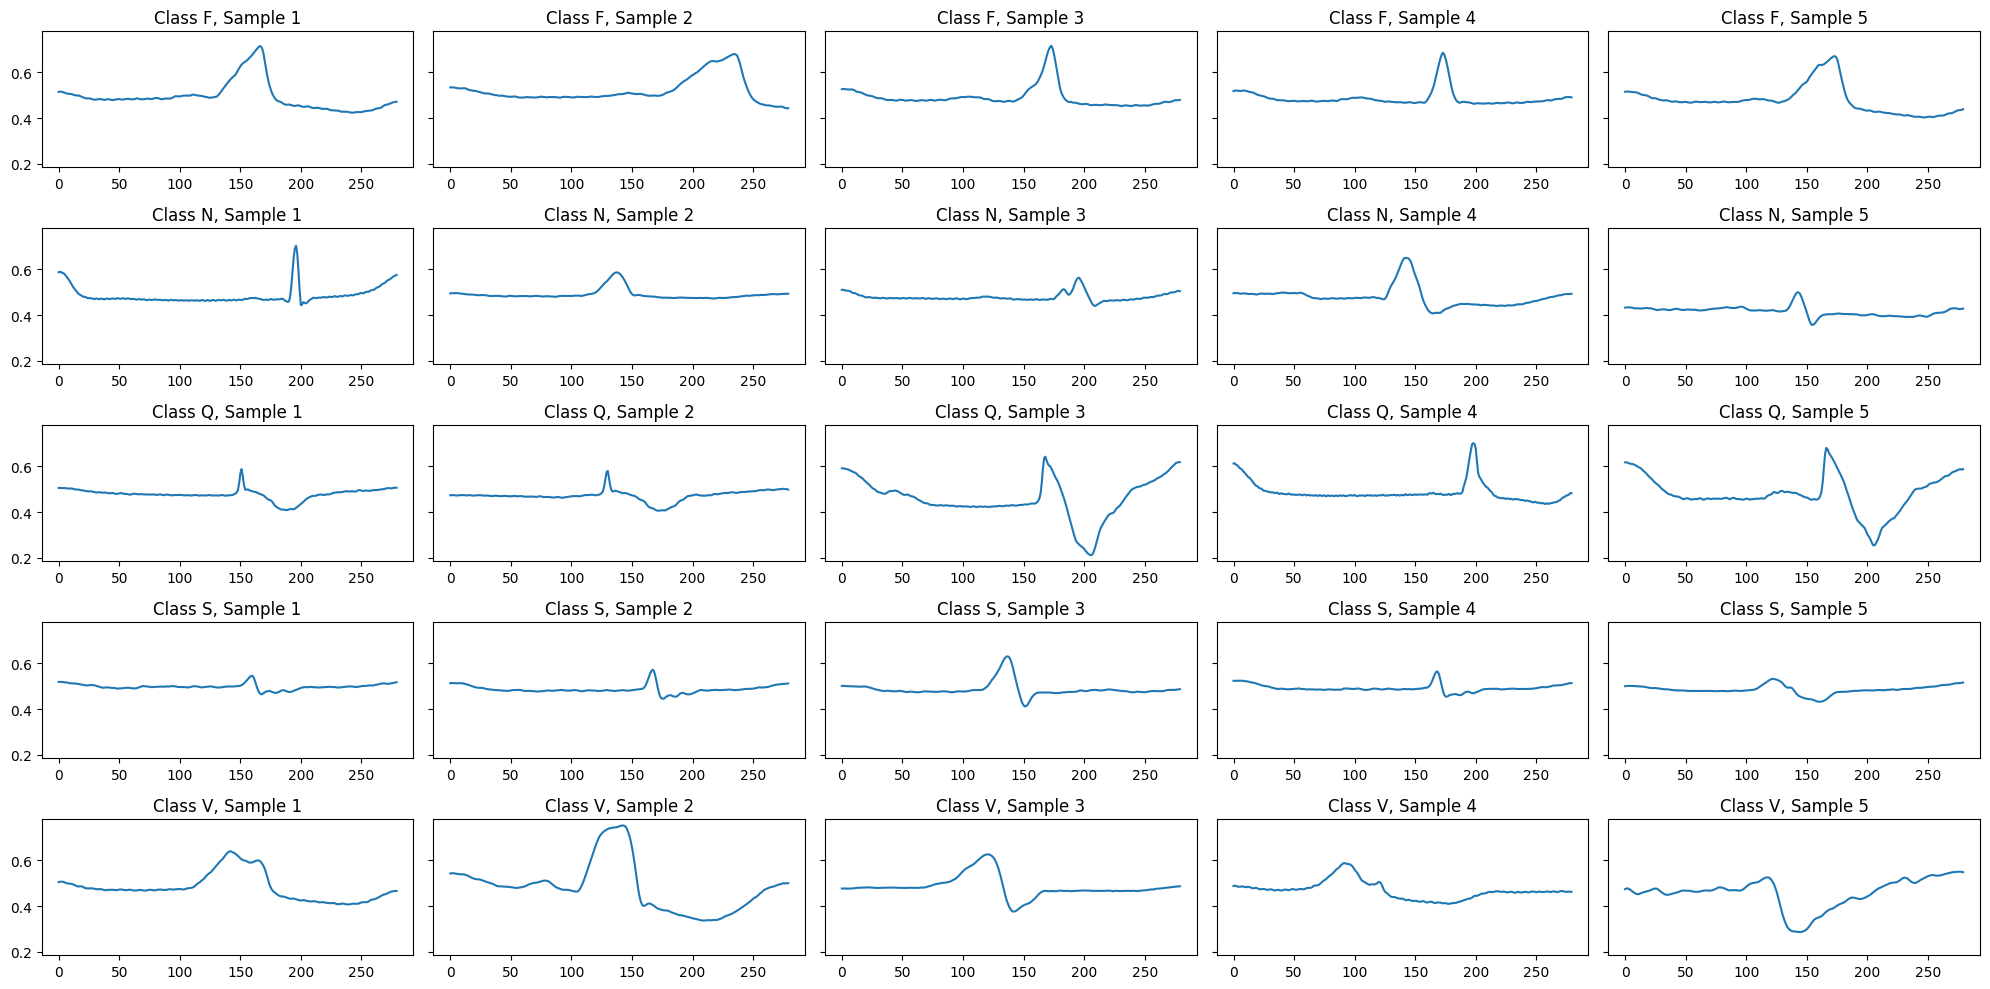

In [62]:
MITData = data.PhysioNetDataset('MIT-BIH', path='data/MIT-BIH')
record, annotation = MITData.__getitem__(6)
print("ECG shape:", record.p_signal.shape, end='\n')

print("\nkeys in record:")
for key in record.__dict__.keys():
    print('\t'+key+':'+str(record.__dict__[key]))

print("\nkeys in annotation")
for key in annotation.__dict__.keys():
    print('\t'+key+':'+str(annotation.__dict__[key]))

data.plot_info(MITData)

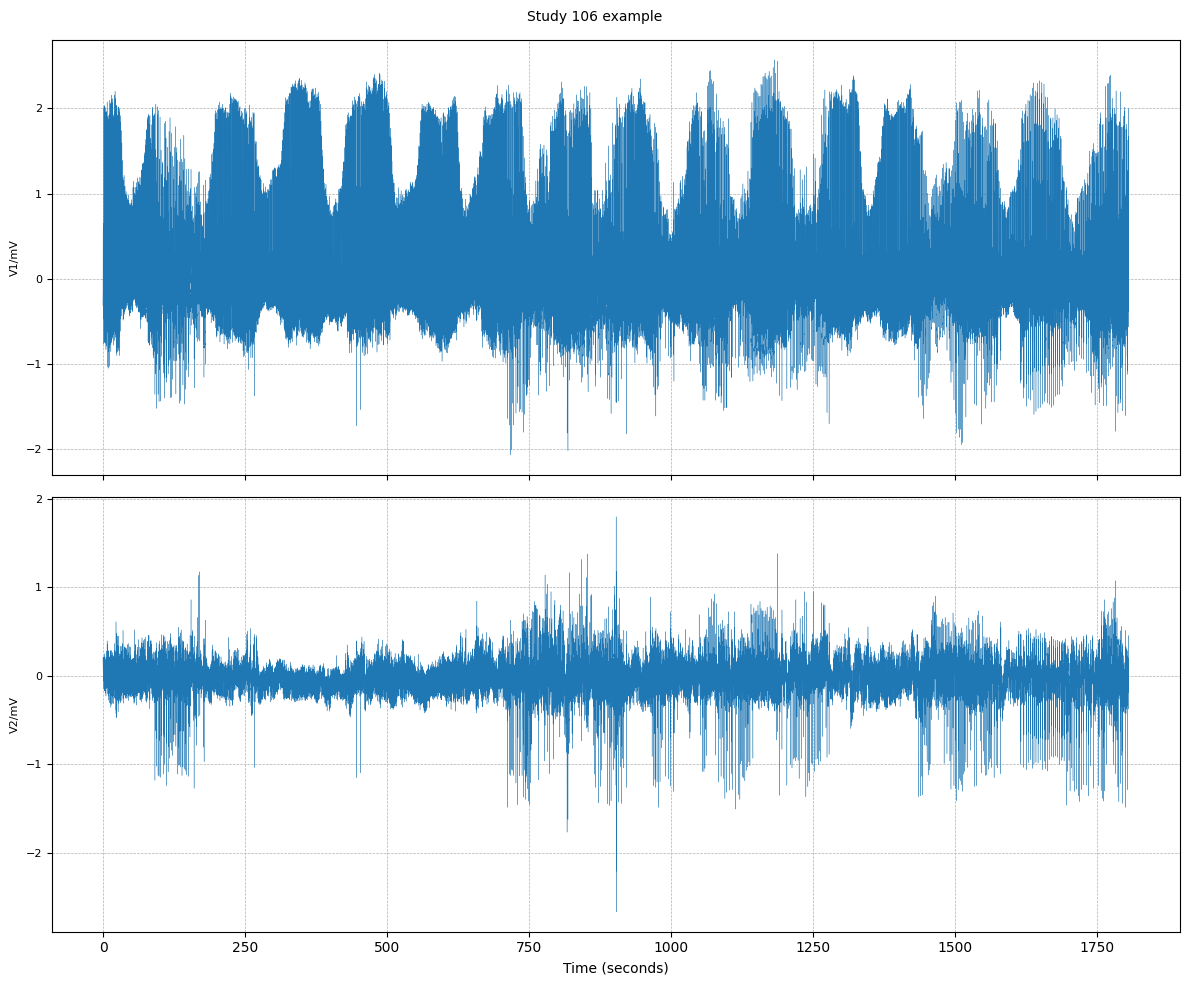

In [49]:
data.plot_ecg(record)

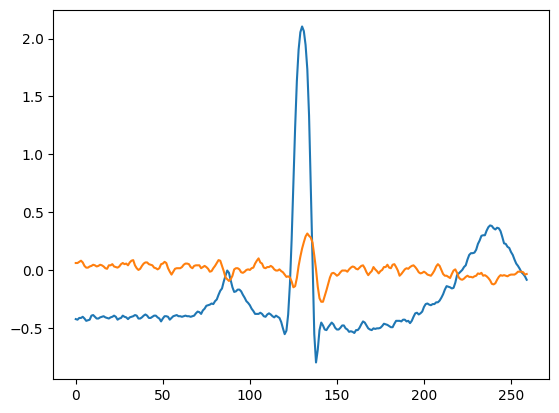

In [53]:
i = 1537
plt.plot(record.p_signal[annotation.sample[i]-130:annotation.sample[i]+130])

### Preprocesamiento

En annotation.sample están los índices de las muestras con eventos anotados

En annotation.symbol están los símbolos correspondientes a los eventos anotados

Por tanto, len(annotation.sample) == len(annotation.symbol)

Ejemplo de R-R

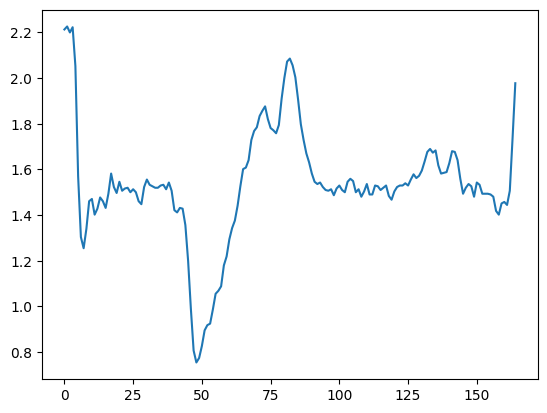

In [15]:
dataset = INCARTData
plt.plot(record.p_signal[annotation.sample[1]:annotation.sample[2], INCARTData.lead])

thisON: 428
thisOFF: 448
lastOFF: 448


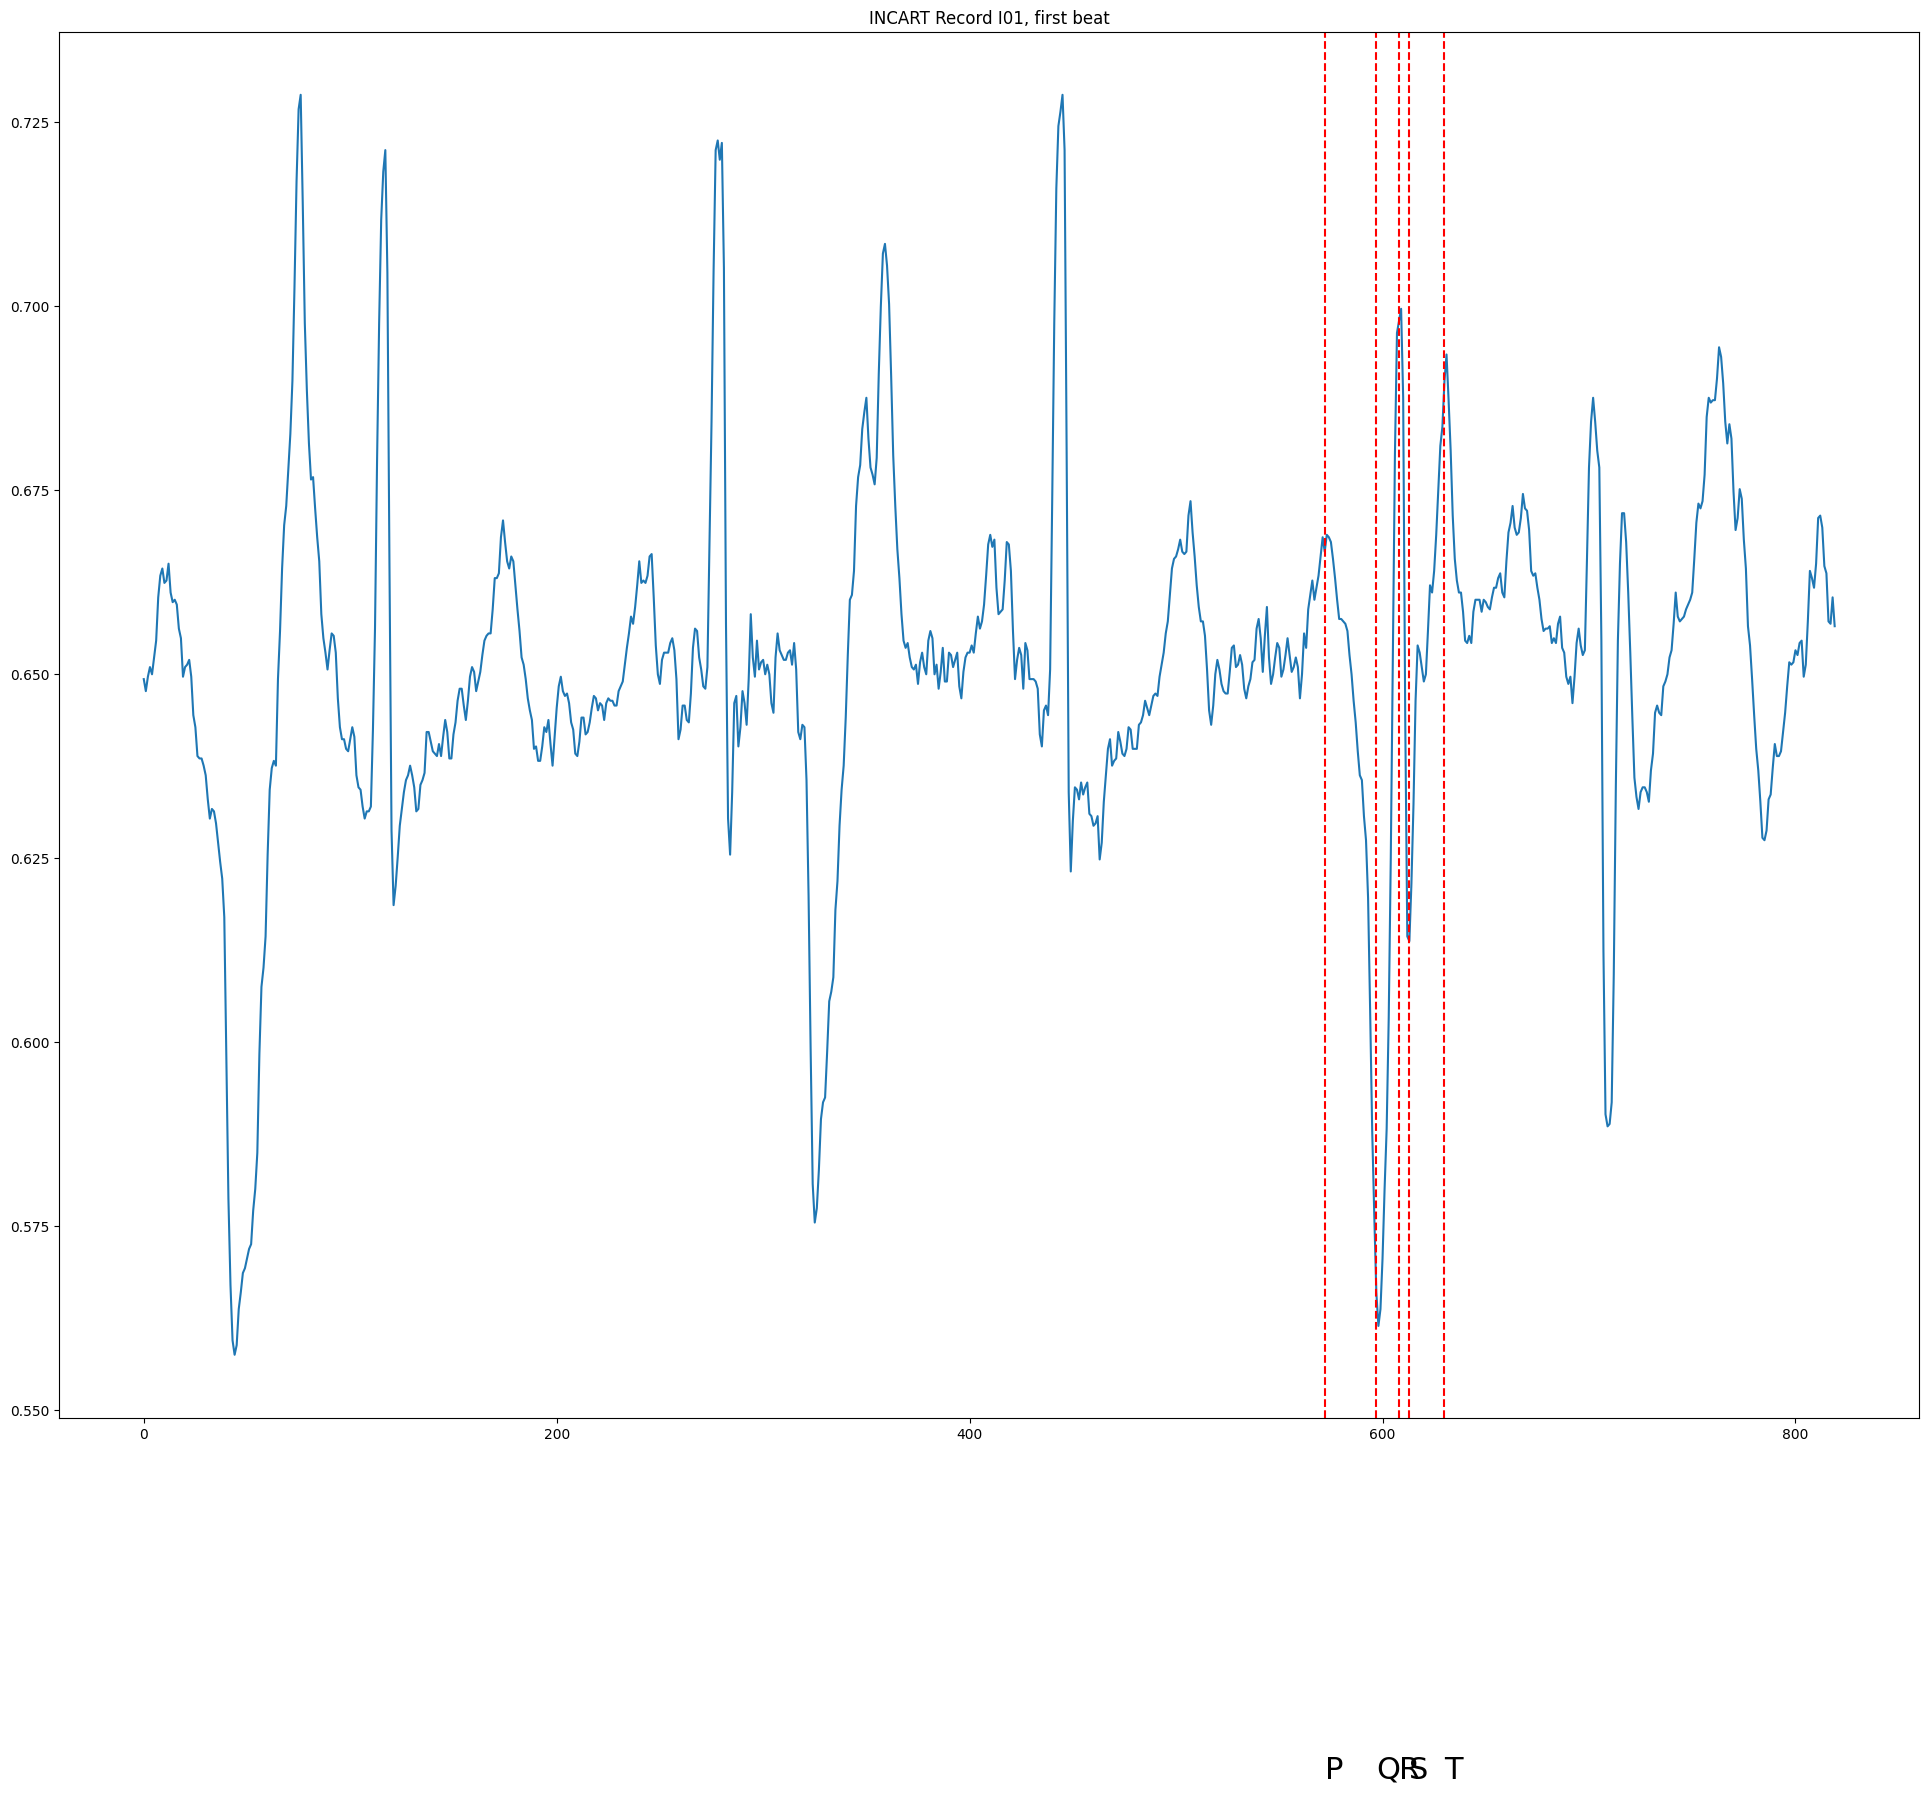

In [21]:
ECG = record.p_signal[:, dataset.lead] # Usar la primera señal (Lead I)
# Normalize signal
ECG = data.normalize(ECG)
fs = record.fs # Frecuencia de muestreo

# Picos R
Rposition = annotation.sample


# ----- Q, S peaks detection ----- # Esto se debería embeber en una función
aveHB = len(ECG) / len(Rposition) # Average heart beat length

# Initialize an array to store the fiducial points
fid_pks = np.zeros((len(Rposition), 7), dtype=int)
# fiducial points: P wave onset, Q wave onset, R wave peak, 
# S wave onset, T wave onset, R wave offset, T wave offset

# Set up the search windows (in samples)
windowS = round(fs * 0.1)
windowQ = round(fs * 0.05)
windowP = round(aveHB / 3)
windowT = round(aveHB * 2 / 3)
windowOF = round(fs * 0.04)

# Process each R position # Esto debería ser otra función
for i in range(5):
    thisR = Rposition[i]
    
    # First
    if i == 0:
        fid_pks[i, 3] = thisR
        fid_pks[i, 5] = thisR + windowS

    if (thisR + windowT) < len(ECG) and (thisR - windowP) >= 1:
        # Detect Q and S peaks
        fid_pks[i, 3] = thisR
        Sp = np.argmin(ECG[thisR:thisR + windowS])
        thisS = Sp + thisR
        fid_pks[i, 4] = thisS
        Qp = np.argmin(ECG[thisR - windowQ:thisR])
        thisQ = thisR - (windowQ + 1) + Qp
        fid_pks[i, 2] = thisQ
        
        # Detect QRS onset and offset
        interval_q = ECG[thisQ - windowOF:thisQ]
        thisON = thisQ - (windowOF + 1) + data.onoffset(interval_q, 'on')
        
        interval_s = ECG[thisS:thisS + windowOF]
        thisOFF = thisS + data.onoffset(interval_s, 'off') - 1
        
        fid_pks[i, 1] = thisON
        fid_pks[i, 5] = thisOFF

        if i == 2:
            print("thisON:", thisON)
            print("thisOFF:", thisOFF)
            print("lastOFF:", fid_pks[i, 5])

for i in range(1,4):    # Detect P and T waves
    lastOFF = fid_pks[i - 1, 5]
    thisON = fid_pks[i, 1]
    thisOFF = fid_pks[i, 5]
    nextON = fid_pks[i + 1, 1]

    # El inicio del complejo QRS actual (thisON) se produce después 
    # de que haya terminado el complejo anterior (lastOFF)
    # El final del complejo QRS actual (thisOFF) ocurre antes del inicio 
    # del siguiente complejo (nextON).

    if thisON > lastOFF and thisOFF < nextON:
        Tzone = ECG[thisOFF:int(nextON - round((nextON - thisOFF) / 3))]
        Pzone = ECG[lastOFF + int(round(2 * (thisON - lastOFF) / 3)):thisON]
        
        thisT = np.argmax(Tzone)
        thisP = np.argmax(Pzone)
        
        fid_pks[i, 0] = lastOFF + round(2 * (thisON - lastOFF) / 3) + thisP - 1
        fid_pks[i, 6] = thisOFF + thisT - 1

# Plot the ECG signal
i = 3
plt.figure(figsize=(24, 18))
plt.plot(ECG[0:820])
plt.axvline(x=fid_pks[i,0], color='r', linestyle='--')
plt.text(fid_pks[i,0], 0.5, 'P', fontsize=22)
plt.axvline(x=fid_pks[i,2], color='r', linestyle='--')
plt.text(fid_pks[i,2], 0.5, 'Q', fontsize=22)
plt.axvline(x=fid_pks[i,3], color='r', linestyle='--')
plt.text(fid_pks[i,3], 0.5, 'R', fontsize=22)
plt.axvline(x=fid_pks[i,4], color='r', linestyle='--')
plt.text(fid_pks[i,4], 0.5, 'S', fontsize=22)
plt.axvline(x=fid_pks[i,6], color='r', linestyle='--')
plt.text(fid_pks[i,6], 0.5, 'T', fontsize=22)
plt.title('INCART Record I01, first beat')
# show plot between 0 an 1 in the x axis
#plt.xlim(0, 1)
plt.show()

In [61]:
def qsPeaks(ECG, Rposition, fs):
    """
    Q, S peaks detection.
    
    :param ECG: The ECG signal
    :param Rposition: Positions of R-peaks
    :param fs: Sampling frequency
    :return: ECGpeaks (detected Q, S, P, T peaks)
    """
    # Average heart beat length
    aveHB = len(ECG) / len(Rposition)
    
    # Initialize an array to store the fiducial points
    fid_pks = np.zeros((len(Rposition), 7), dtype=int)
    # fiducial points: P wave onset, Q wave onset, R wave peak, 
    # S wave onset, T wave onset, R wave offset, T wave offset
    
    # Set up the search windows (in samples)
    windowS = round(fs * 0.1)
    windowQ = round(fs * 0.05)
    windowP = round(aveHB / 3)
    windowT = round(aveHB * 2 / 3)
    windowOF = round(fs * 0.04)
    
    # Process each R-position
    for i in range(len(Rposition)):
        thisR = Rposition[i]
        
        # First
        if i == 0:
            fid_pks[i, 3] = thisR
            fid_pks[i, 5] = thisR + windowS
        # Last
        elif i == len(Rposition) - 1:
            fid_pks[i, 3] = thisR
            fid_pks[i, 1] = thisR - windowQ
        else:
            if (thisR + windowT) < len(ECG) and (thisR - windowP) >= 1:
                # Detect Q and S peaks
                fid_pks[i, 3] = thisR
                Sp = np.argmin(ECG[thisR:thisR + windowS])
                thisS = Sp + thisR
                fid_pks[i, 4] = thisS
                Qp = np.argmin(ECG[thisR - windowQ:thisR])
                thisQ = thisR - (windowQ + 1) + Qp
                fid_pks[i, 2] = thisQ
                
                # Detect QRS onset and offset
                interval_q = ECG[thisQ - windowOF:thisQ]
                thisON = thisQ - (windowOF + 1) + onoffset(interval_q, 'on')
                
                interval_s = ECG[thisS:thisS + windowOF]
                thisOFF = thisS + onoffset(interval_s, 'off') - 1
                
                fid_pks[i, 1] = thisON
                fid_pks[i, 5] = thisOFF
    
    # Detect P and T waves
    for i in range(1, len(Rposition) - 1):
        lastOFF = fid_pks[i - 1, 5]
        thisON = fid_pks[i, 1]
        thisOFF = fid_pks[i, 5]
        nextON = fid_pks[i + 1, 1]
        
        if thisON > lastOFF and thisOFF < nextON:
            Tzone = ECG[thisOFF:int(nextON - round((nextON - thisOFF) / 3))]
            Pzone = ECG[lastOFF + int(round(2 * (thisON - lastOFF) / 3)):thisON]
            
            thisT = np.argmax(Tzone)
            thisP = np.argmax(Pzone)
            
            fid_pks[i, 0] = lastOFF + round(2 * (thisON - lastOFF) / 3) + thisP - 1
            fid_pks[i, 6] = thisOFF + thisT - 1
    
    # Filter out invalid peaks (those with 0 value)
    #ECGpeaks = []
    #for i in range(len(Rposition)):
        #if np.prod(fid_pks[i, :]) != 0:
    #    ECGpeaks.append(fid_pks[i, :])
    
    return np.array(fid_pks) #np.array(ECGpeaks)

In [62]:
n_cycles = 0

signal = record.p_signal[:, 0] # Usar la primera señal (Lead I)
Fs = record.fs # Frecuencia de muestreo

# Detectar los picos R
rPeaks = annotation.sample + 1
n_cycles += len(rPeaks) # 2141
peaks = qsPeaks(signal, rPeaks, Fs)

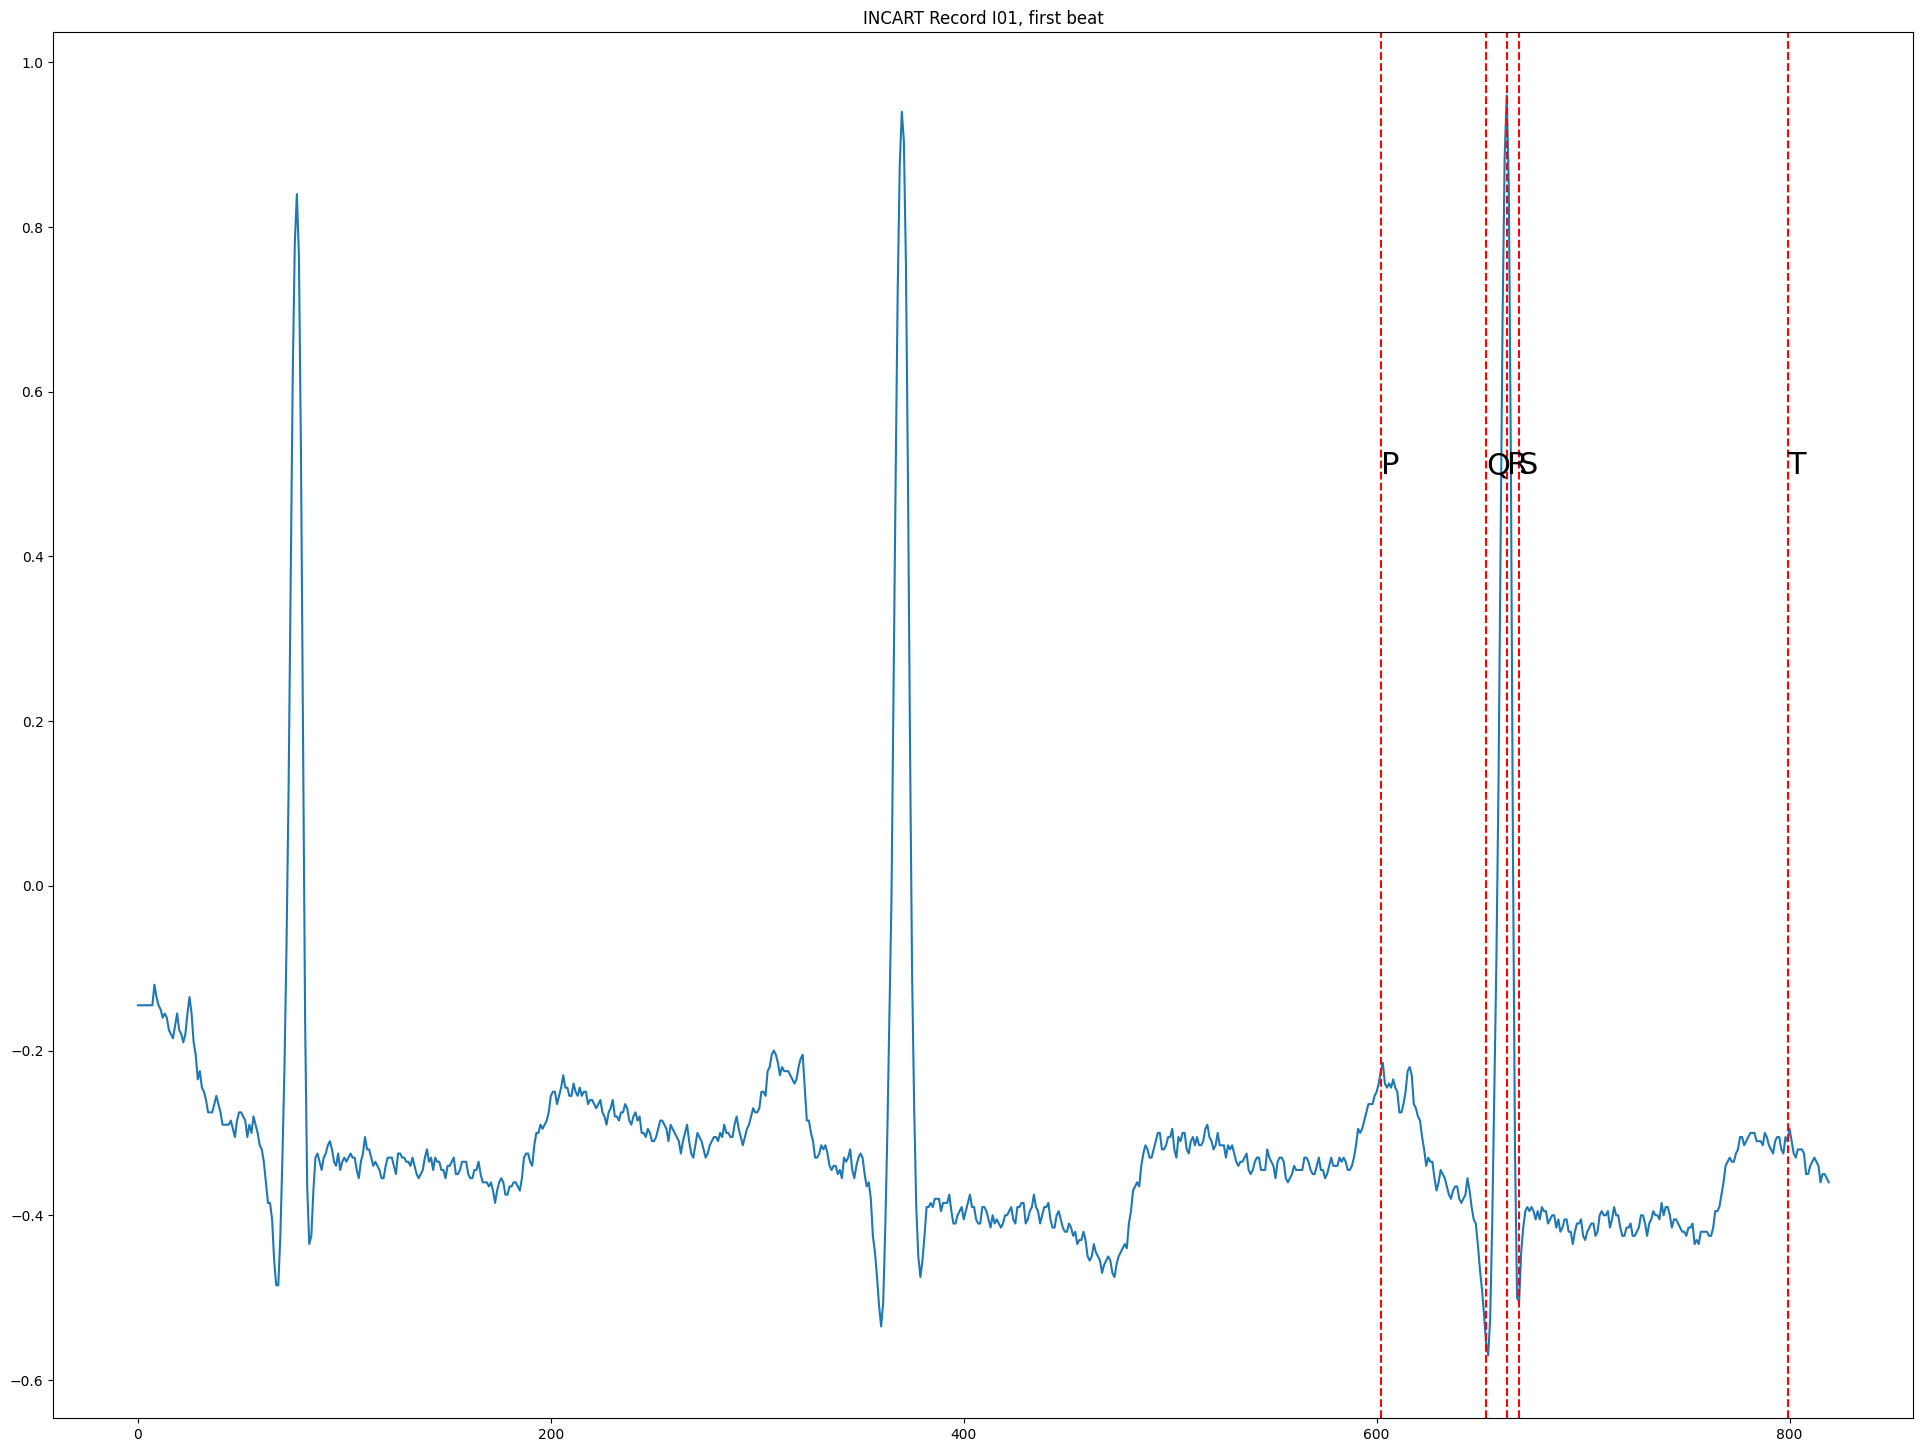

In [63]:
i = 3
plt.figure(figsize=(24, 18))
plt.plot(ECG[0:820])
plt.axvline(x=peaks[i,0], color='r', linestyle='--')
plt.text(peaks[i,0], 0.5, 'P', fontsize=22)
plt.axvline(x=peaks[i,2], color='r', linestyle='--')
plt.text(peaks[i,2], 0.5, 'Q', fontsize=22)
plt.axvline(x=peaks[i,3], color='r', linestyle='--')
plt.text(peaks[i,3], 0.5, 'R', fontsize=22)
plt.axvline(x=peaks[i,4], color='r', linestyle='--')
plt.text(peaks[i,4], 0.5, 'S', fontsize=22)
plt.axvline(x=peaks[i,6], color='r', linestyle='--')
plt.text(peaks[i,6], 0.5, 'T', fontsize=22)
plt.title('INCART Record I01, first beat')
plt.show()

In [67]:
beat_len = 280 # longitud predefinida de los segmentos
tpeaks = peaks[:, 6]

N_class = 0
S_class = 0
V_class = 0
F_class = 0
Q_class = 0

# Agrupar las anotaciones en clases AAMI
annot = annotation.symbol
seg_values_classified = []
seg_labels_classified = []

for ind, annot_val in enumerate(annot):
    if annot_val in ['N', 'L', 'R', 'e', 'j']:
        label = 'N'
        N_class += 1
    elif annot_val in ['A', 'a', 'J', 'S']:
        label = 'S'
        S_class += 1
    elif annot_val in ['V', 'E']:
        label = 'V'
        V_class += 1
    elif annot_val == 'F':
        label = 'F'
        F_class += 1
    elif annot_val in ['/', 'f', 'Q']:
        label = 'Q'
        Q_class += 1
    else:
        continue  # Si la anotación no coincide, se omite
    
    # Segmentar y normalizar la señal
    if ind == 0:
        segment = signal[:min(Fs, len(signal))]  # Primer segmento
    else:
        segment = signal[tpeaks[ind-1]:tpeaks[ind]]  # Segmento entre picos

    if ind == 4:
        break
    
    segment_resized = np.resize(segment, (beat_len,))
    #seg_values_classified.append(segment_resized)
    #seg_labels_classified.append(label)

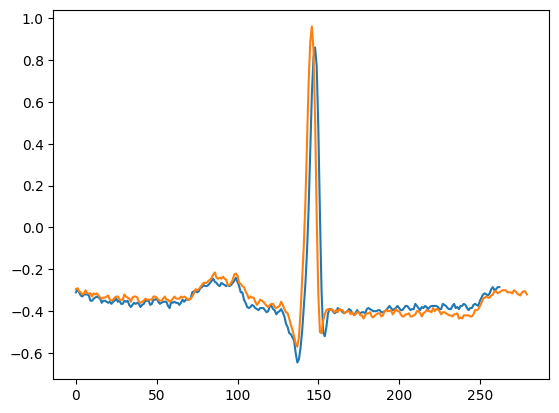

In [69]:
plt.plot(segment)
plt.plot(segment_resized)

Vamos a probar con otra aproximación:

En el R-R definir una ventana para buscar el pico T y retornar simplemente el máximo

/tmp/ipykernel_523768/2145709899.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend() # Add a legend using the `label` arguments above


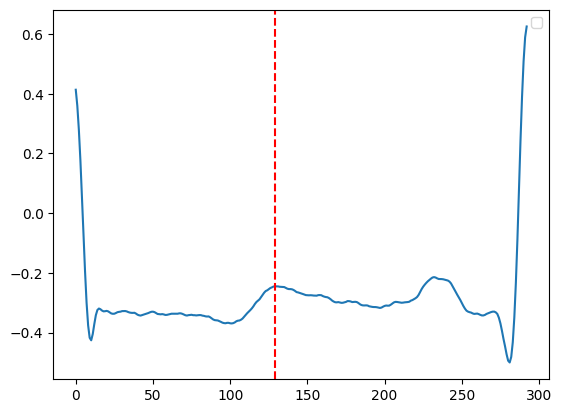

In [58]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

def detect_t(ECG, avg_beat_len):
    """
    Detecta el pico T en un complejo R-R de una señal ECG.
    
    :param ECG: La señal ECG.
    :param r_peak: El índice del pico R.
    :param fs: Frecuencia de muestreo (samples por segundo).
    :param avg_beat_len: Longitud promedio del latido (en muestras).
    :return: El índice del pico T.
    """
    # Calcular las posiciones relativas para las ventanas de búsqueda
    t_window_start = int(avg_beat_len // 6)  # Aproximadamente un cuarto después del pico R
    t_window_end = int(avg_beat_len // 2)  # Aproximadamente la mitad después del pico R

    # Asegurarse de que el índice no se salga de los límites de la señal
    if t_window_end > len(ECG):
        t_window_end = len(ECG)
    
    t_window = ECG[t_window_start:t_window_end]
    
    # Buscar el pico T, que es el máximo dentro de la ventana
    t_peak = np.argmax(t_window)
    
    # Devolver el índice global del pico T
    t_peak += t_window_start
    return t_peak

# Ejemplo de uso:
# Suponiendo que `ECG` es la señal ECG y `r_peaks` contiene los índices de los picos R
ECG = record.p_signal[:, 0]  # Usar la primera señal (Lead I)
ECG_sm = scipy.signal.savgol_filter(ECG, window_length=20, polyorder=2)
r_peaks = annotation.sample  # Picos R 
rr_interval = ECG_sm[r_peaks[1]:r_peaks[2]]
fs = record.fs  # Frecuencia de muestreo (por ejemplo, 360 Hz)
avg_beat = len(ECG) / len(r_peaks)

pks = detect_t(rr_interval, avg_beat)

# Visualización de los picos detectados
plt.plot(rr_interval)
plt.axvline(x=pks, color='r', linestyle='--')
plt.legend() # Add a legend using the `label` arguments above
plt.show()

Ahora vamos a probar para varios

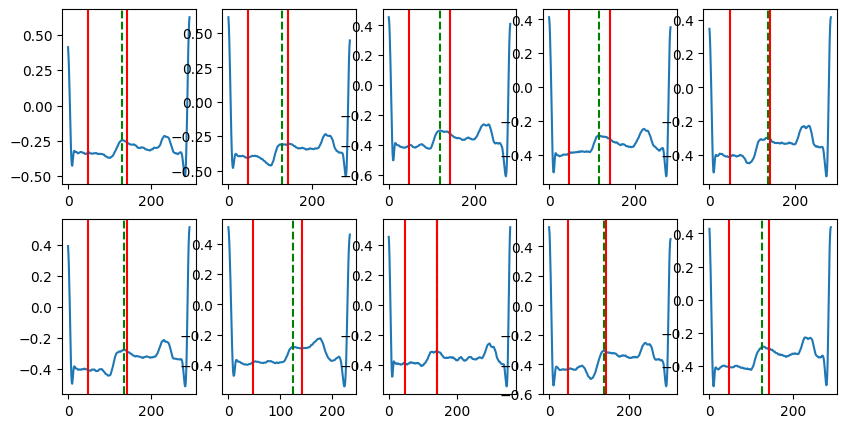

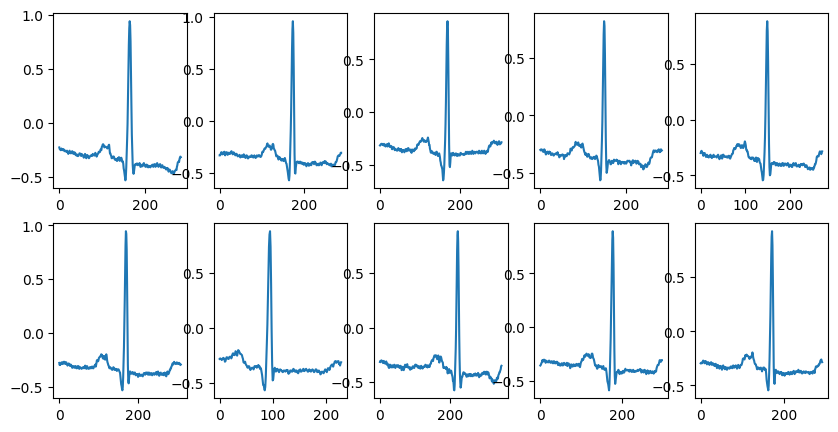

In [61]:
ECG = record.p_signal[:, 0] 
ECG_sm = scipy.signal.savgol_filter(ECG, window_length=20, polyorder=2) # windows length dependerá del dataset
t_peaks = []
r_peaks = annotation.sample
avg_beat = len(ECG) / len(r_peaks)

for i in range(1, len(r_peaks) - 1):
    rr_interval = ECG_sm[r_peaks[i]:r_peaks[i+1]]

    t_peaks.append(detect_t(rr_interval, avg_beat))

plt.figure(figsize=(10, 5))
for i in range(1,11):
    rr_interval = ECG_sm[r_peaks[i]:r_peaks[i+1]]
    t_peak = t_peaks[i-1]
    plt.subplot(2, 5, i)
    plt.plot(rr_interval)
    plt.axvline(x=t_peak, color='g', linestyle='--')
    plt.axvline(x=47, color='r', linestyle='-')
    plt.axvline(x=142, color='r', linestyle='-')
plt.show()

plt.figure(figsize=(10, 5))
for i in range(2,12):
    tt_segment = ECG[r_peaks[i-1]+t_peaks[i-1]:r_peaks[i]+t_peaks[i]]
    plt.subplot(2, 5, i-1)
    plt.plot(tt_segment)
plt.show()

Problema: La distancia entre latidos es tremendamente variable. En una taquicardia podría ser del orden de 300 ms. Para una persona en reposo con una buena forma física, o para alguien "normal" mientras duerme, podría llegar fácilmente a los 1200 ms o más. La longitud promedio de los latidos en un registro largo (holter de 24 horas, el escenario precisamente donde es más interesante un análisis automático) es bien poco útil. Durante taquicardias, o si la persona está haciendo ejercicio, esa ventana promedio fácilmente va englobar más de un latido, o al menos partes del siguiente latido.